# Лемешев Игорь КИ22-17-1Б Анализ временных рядов Вариант 3 Coal Power



# Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings("ignore")
coal = pd.read_csv("data/Coal Power.csv")
coal.head()


,Unnamed: 0,Total consumption : Texas : electric power (total) : quarterly (short tons)
0,2001 Q1,22164839
1,2001 Q2,22952510
2,2001 Q3,25962808
3,2001 Q4,21357650
4,2002 Q1,21917084


# Предварительная обработка

In [2]:
def parse_quarter(date_str):
    year, quarter = date_str.split(' Q')
    year = int(year)
    quarter = int(quarter)
    return pd.Timestamp(year=year, month=(quarter - 1) * 3 + 1, day=1)
coal.columns = ['Date', 'Total Consumption']
coal['Date'] = coal['Date'].apply(parse_quarter)
coal.set_index('Date', inplace=True)
coal.head()

,Total Consumption
Date,
2001-01-01,22164839
2001-04-01,22952510
2001-07-01,25962808
2001-10-01,21357650
2002-01-01,21917084


Лучшая модель AR:
Порядок: (1, 0, 0)
Сезонный порядок: (0, 1, 1, 4)
None
AIC: 2309978.350666138

Лучшая модель MA:
Порядок: (0, 0, 3)
Сезонный порядок: (1, 1, 0, 4)
None
AIC: 2348572.0702463756

Лучшая модель ARMA:
Порядок: (1, 0, 3)
Сезонный порядок: (0, 1, 0, 4)
None
AIC: 2206679.21429986

Лучшая модель ARIMA:
Порядок: (1, 5, 5)
Сезонный порядок: (0, 0, 0, 4)
None
AIC: 1567827.8885973017


# График временного ряда

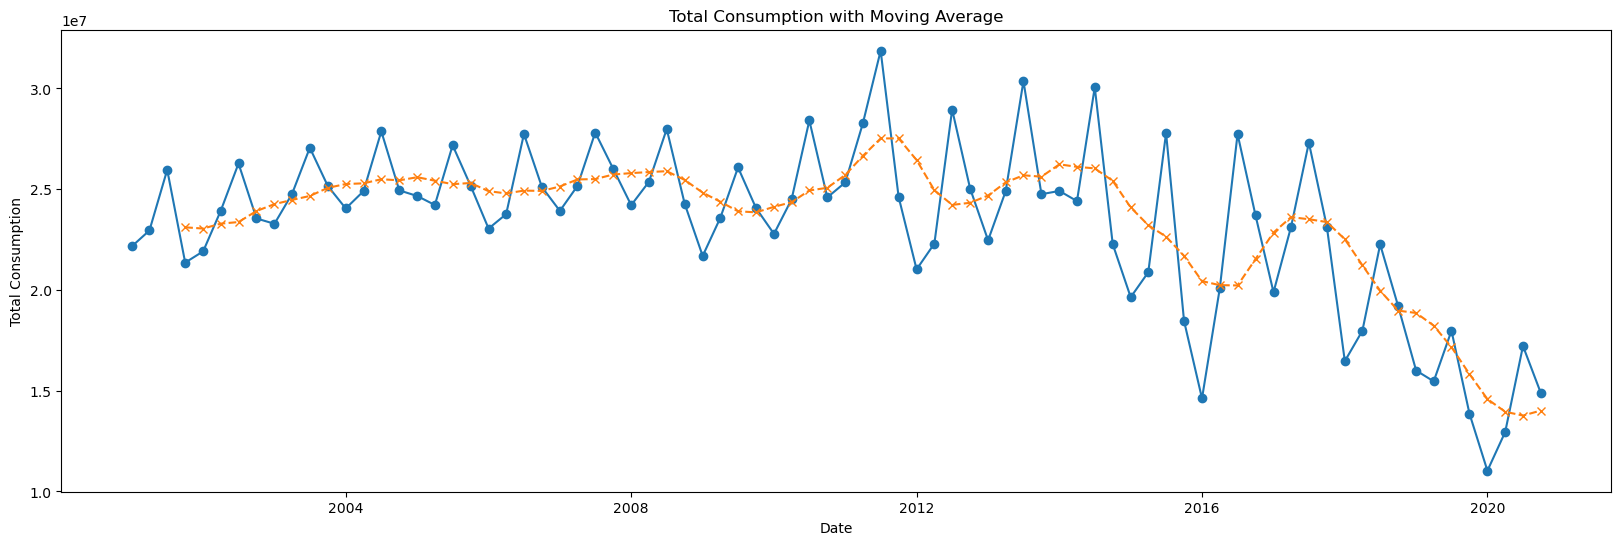

In [11]:

plt.figure(figsize=(20, 6))
plt.plot(coal.index, coal, marker='o', label='Total Consumption')
plt.plot(coal.index, coal.rolling(window=4).mean(), marker='x', linestyle='--', label='Moving Average')

plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.title('Total Consumption with Moving Average')
plt.show()

# Проверка временного ряда на стационарность

ADF Statistic: 1.976303
p-value: 0.998641
ADF Statistic: -4.640141
p-value: 0.000109


<Axes: xlabel='Date'>

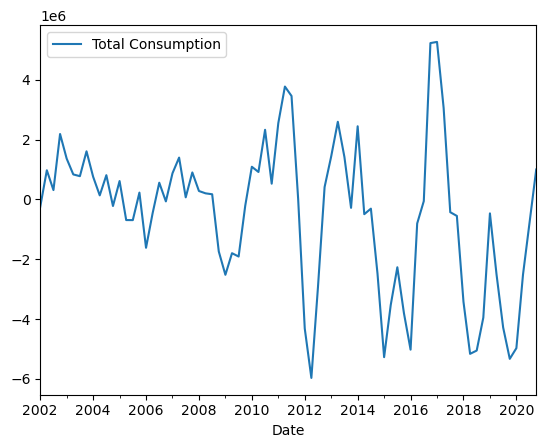

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(coal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
    
coal_diff = coal.diff(4).dropna()

result_diff = adfuller(coal_diff)
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])

    
coal_diff.plot()

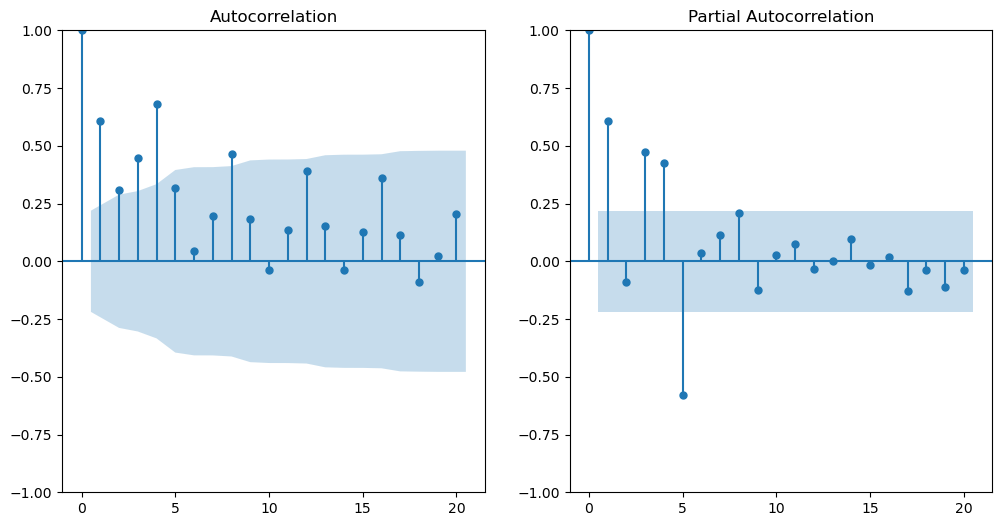

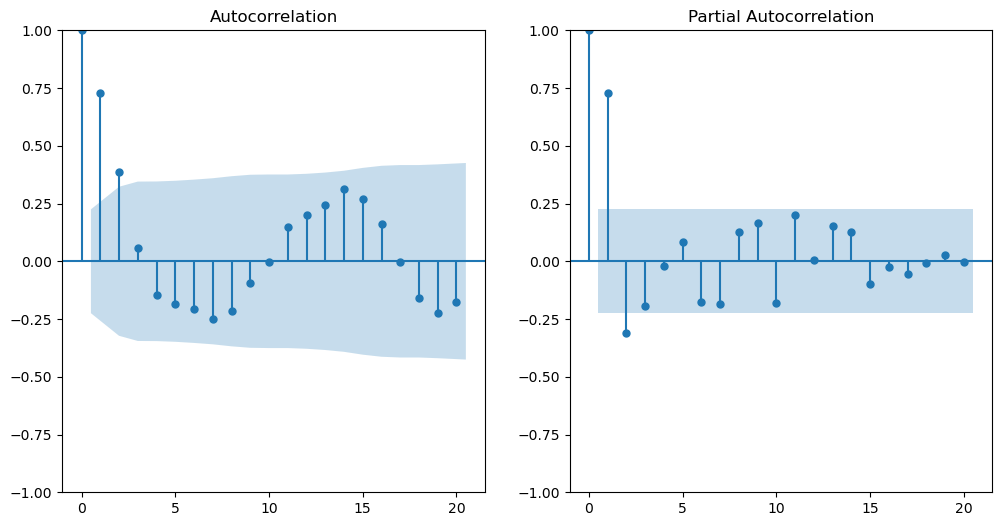

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(coal, ax=plt.gca())
plt.subplot(122)
plot_pacf(coal, ax=plt.gca())
plt.show()


plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(coal_diff, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(coal_diff, lags=20, ax=plt.gca())
plt.show()

# Описательные статистики

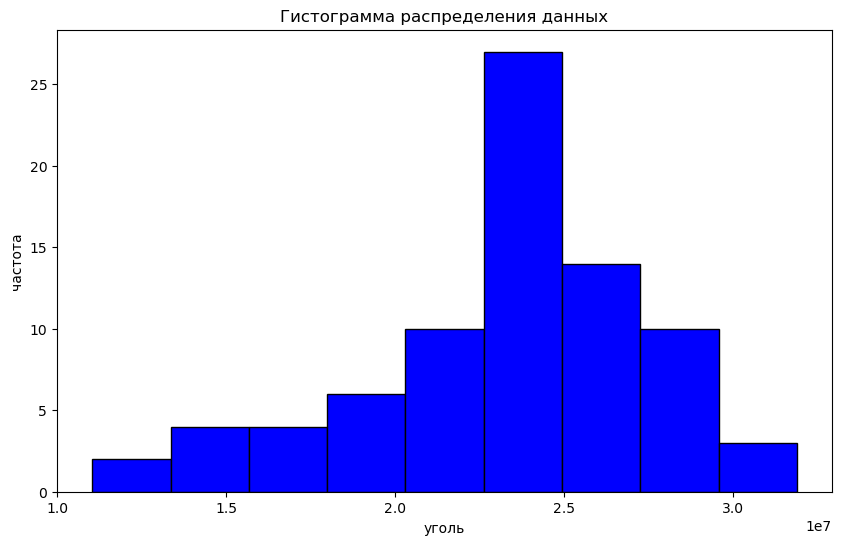

count    8.000000e+01
mean     2.330880e+07
std      4.137809e+06
min      1.102928e+07
25%      2.186000e+07
50%      2.413629e+07
75%      2.534612e+07
max      3.187314e+07
Name: Total Consumption, dtype: float64

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(coal['Total Consumption'], bins=9, color='blue', edgecolor='black')
plt.title('Гистограмма распределения данных')
plt.xlabel('уголь')
plt.ylabel('частота')
plt.show()
description = coal['Total Consumption'].describe()
description 

 в датасете 80 наблюдений, они происходят раз в 4 месяца. 
 
 средний объем угля 23300000
 
 Медиана составляет 24136290 угля. Это значение близко к среднему, распределение данных относительно симметричное
и большое количество наблюдений сосредоточено около среднего значения

# Исследование тренда и сезонности

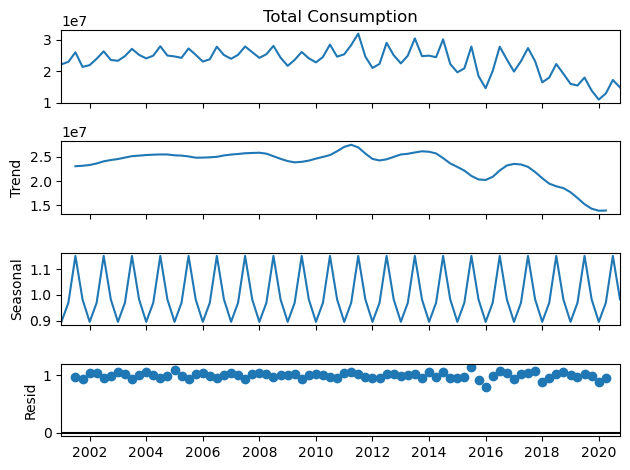

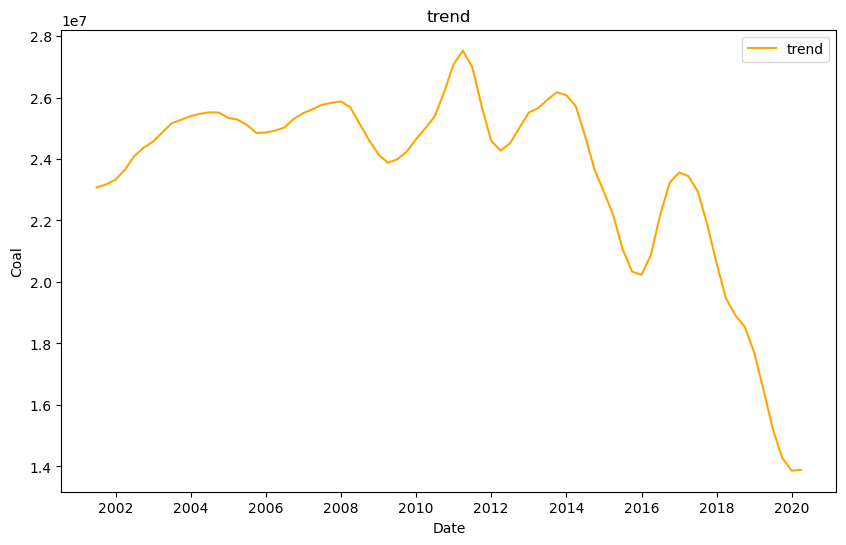

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Декомпозиция
decomposition = seasonal_decompose(coal['Total Consumption'], model='multiplicative', period=4)
decomposition.plot()
plt.show()
trend = decomposition.trend.dropna()
plt.figure(figsize=(10, 6))
plt.plot(trend, label='trend', color='orange')
plt.title('trend')
plt.xlabel('Date')
plt.ylabel('Coal')
plt.legend()
plt.show()





# Проверка гипотезы о наличии тренда

Коэффициент наклона: -88915.44787935748


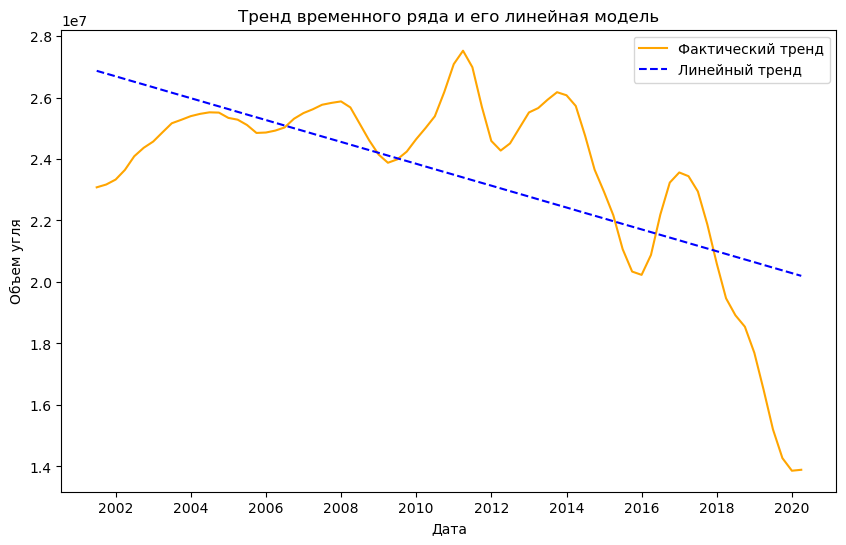

In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values

model = LinearRegression()
model.fit(X, y)

trend_pred = model.predict(X)
slope = model.coef_[0] 

print(f'Коэффициент наклона: {slope}')

plt.figure(figsize=(10, 6))
plt.plot(trend, label='Фактический тренд', color='orange')
plt.plot(trend.index, trend_pred, label='Линейный тренд', color='blue', linestyle='--')
plt.title('Тренд временного ряда и его линейная модель')
plt.xlabel('Дата')
plt.ylabel('Объем угля')
plt.legend()
plt.show()

тренд наклона отрицательный, следовательно происходит снижение тренда

In [17]:
r_squared = model.score(X, y)
print(f'Коэффициент детерминации (R^2): {r_squared}')

Коэффициент детерминации (R^2): 0.40511571170805716


коофицент невысок, так что вероятно влияние тренда на построение модели будет не слишком большим

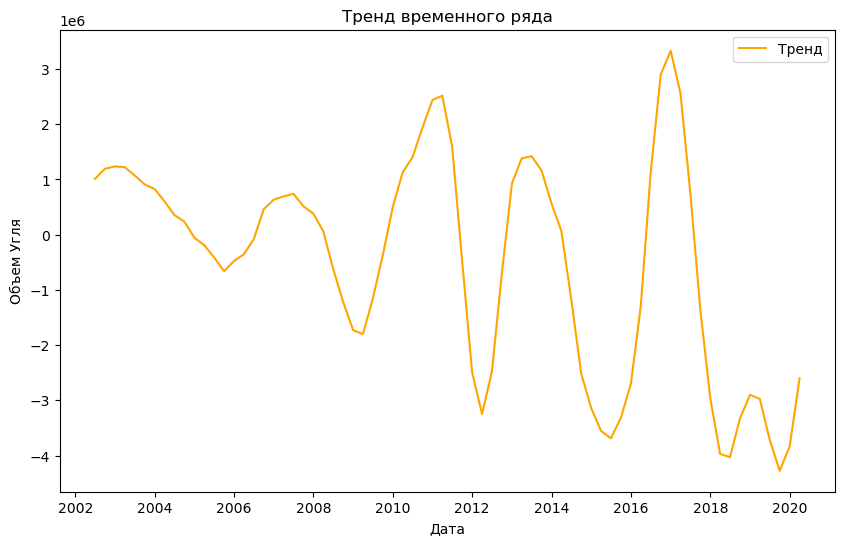

In [18]:
decomposition = seasonal_decompose(coal_diff, model='additive')
trend = decomposition.trend.dropna()
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Тренд', color='orange')
plt.title('Тренд временного ряда')
plt.xlabel('Дата')
plt.ylabel('Объем Угля')
plt.legend()
plt.show()

# Подбор гиперпараметров для исследуемых моделей

In [19]:
datasets = {
    "differenced_4": coal.diff(4).dropna()
}

from statsmodels.tsa.statespace.sarimax import SARIMAX

def find_best_model(model_type, p_range, d_range, q_range, seasonal_range, datasets):
    results = []
    for data_name, data in datasets.items():
        for d in d_range:
            for p in p_range:
                for q in q_range:
                    for P in seasonal_range:
                        for D in range(0,3): 
                            for Q in seasonal_range:
                                try:
                                    model = SARIMAX(data, order=(p,d,q),
                                                    seasonal_order=(P,D,Q,4),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    result = model.fit(disp=False)
                                    results.append({
                                        'model_type': model_type,
                                        'data': data_name,
                                        'p': p,
                                        'd': d,
                                        'q': q,
                                        'P': P,
                                        'D': D,
                                        'Q': Q,
                                        'AIC': result.aic,
                                        'model': result
                                    })
                                except:
                                    continue
                        
    if results:
        best_model = min(results, key=lambda x: x['AIC'])
        return best_model
    else:
        return None

p_range_ar = range(1,5) 
q_range_ma = range(1,5)  
p_range_arma = range(1,5)
q_range_arma = range(1,5)
p_range_arima = range(1,5)
q_range_arima = range(1,5)
d_range_arima = range(1,5)
seasonal_range = range(0,5)  

best_ar_model = find_best_model('AR', p_range_ar, [0], [0], seasonal_range, datasets)
best_ma_model = find_best_model('MA', [0], [0], q_range_ma, seasonal_range, datasets)
best_arma_model = find_best_model('ARMA', p_range_arma, [0], q_range_arma, seasonal_range, datasets)
best_arima_model = find_best_model('ARIMA', p_range_arima, d_range_arima, q_range_arima, seasonal_range, datasets)

best_models = [best_ar_model, best_ma_model, best_arma_model, best_arima_model]



In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
for model_info in best_models:
    if model_info:
        print(f"Лучшая модель {model_info['model_type']}:")
        print(f"Датасет: {model_info['data']}")
        print(f"Порядок: ({model_info['p']}, {model_info['d']}, {model_info['q']})")
        print(f"Сезонный порядок: ({model_info['P']}, {model_info['D']}, {model_info['Q']}, 4)")
        print(f"AIC: {model_info['AIC']}\n")
        print(model_info['model'].summary())
        

        lb_test = acorr_ljungbox(model_info['model'].resid, lags=[10], return_df=True)
        print(lb_test)
        
        

Лучшая модель AR:
Датасет: differenced_4
Порядок: (3, 0, 0)
Сезонный порядок: (4, 2, 1, 4)
AIC: 1613.3104608923063

                                      SARIMAX Results                                      
Dep. Variable:                   Total Consumption   No. Observations:                   76
Model:             SARIMAX(3, 0, 0)x(4, 2, [1], 4)   Log Likelihood                -797.655
Date:                             Thu, 26 Sep 2024   AIC                           1613.310
Time:                                     12:56:32   BIC                           1630.337
Sample:                                 01-01-2002   HQIC                          1619.770
                                      - 10-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

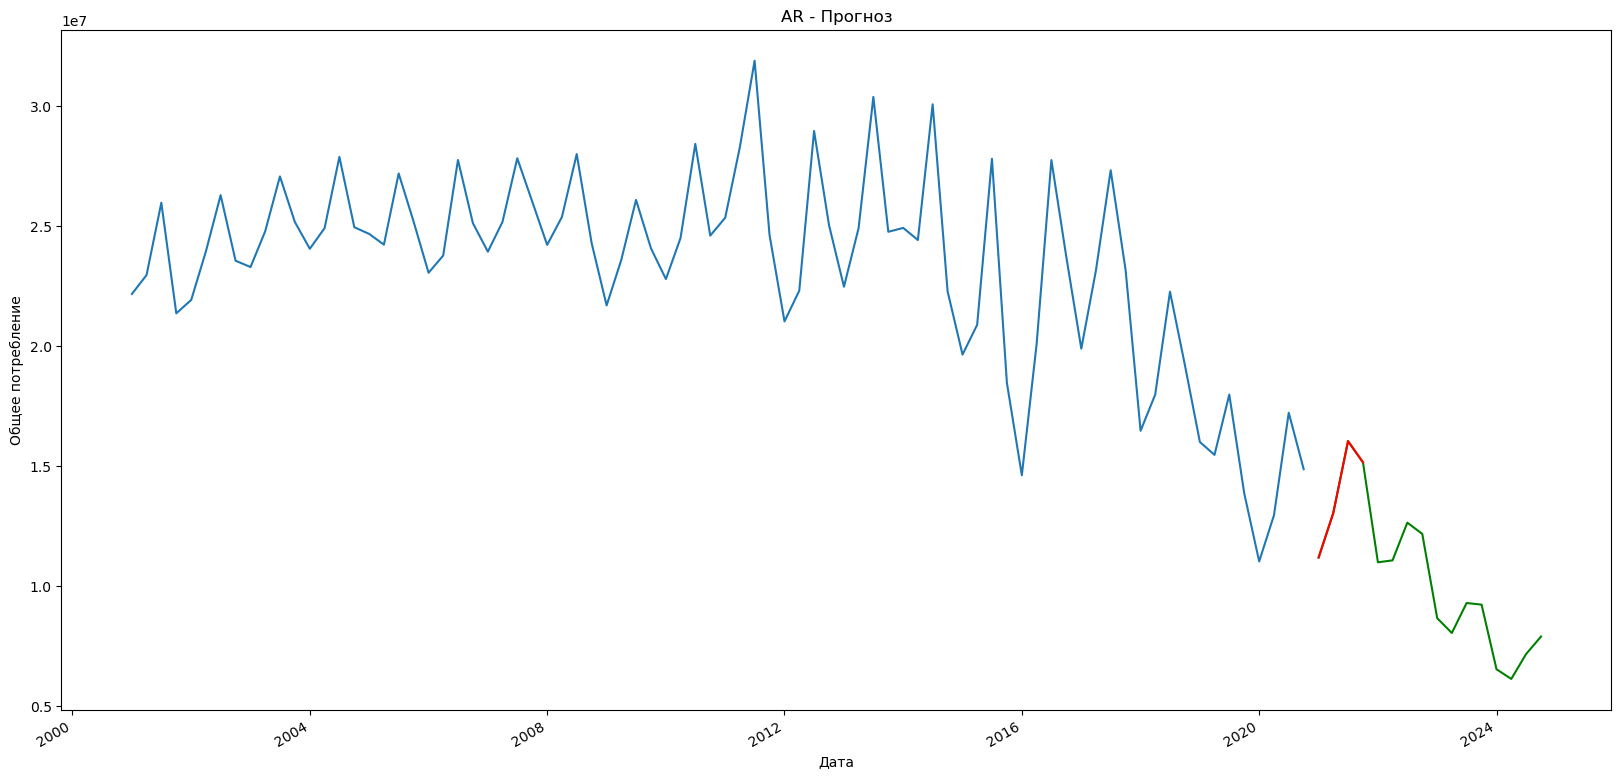

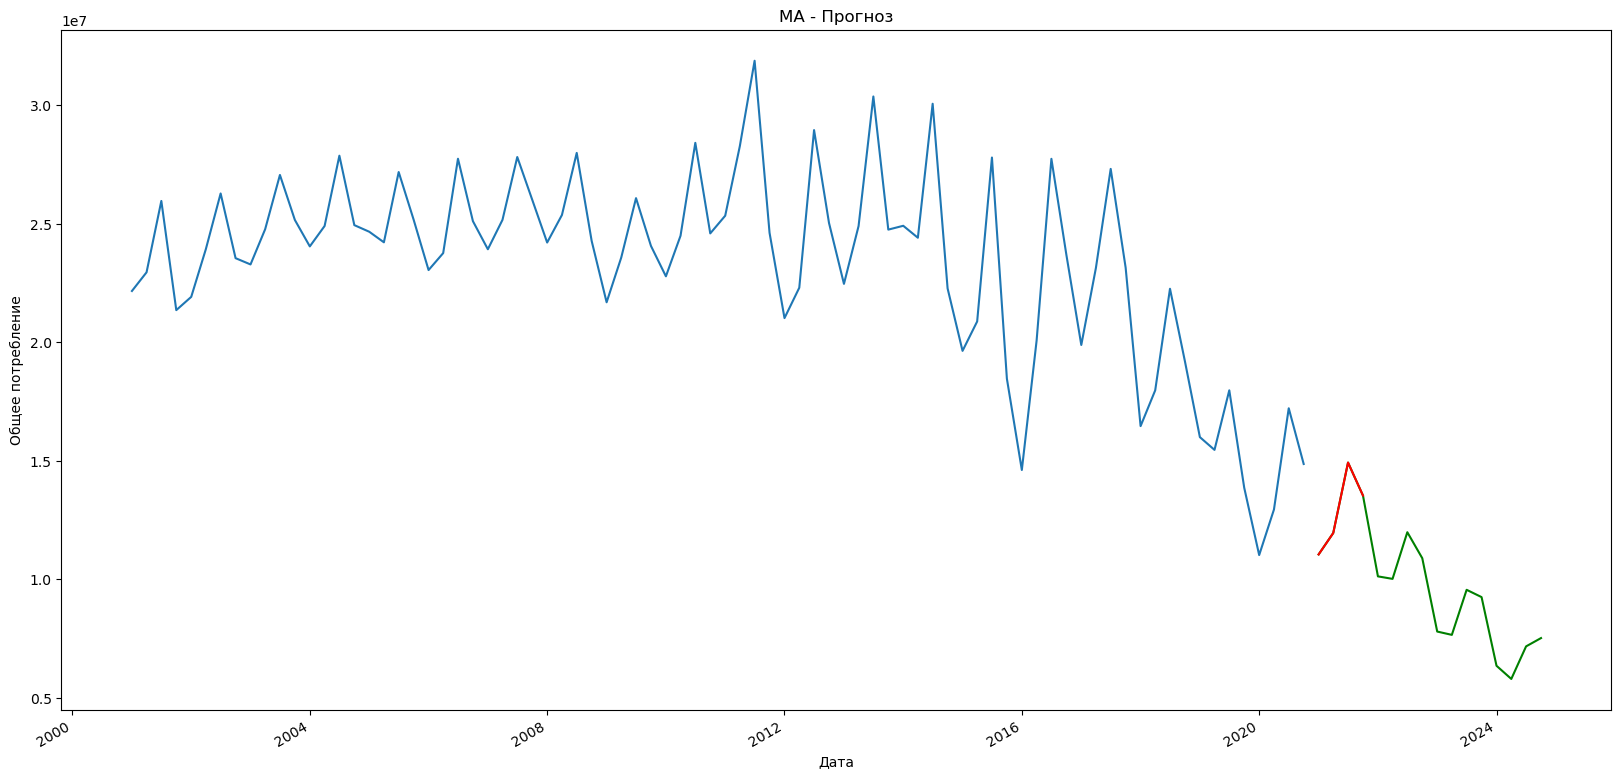

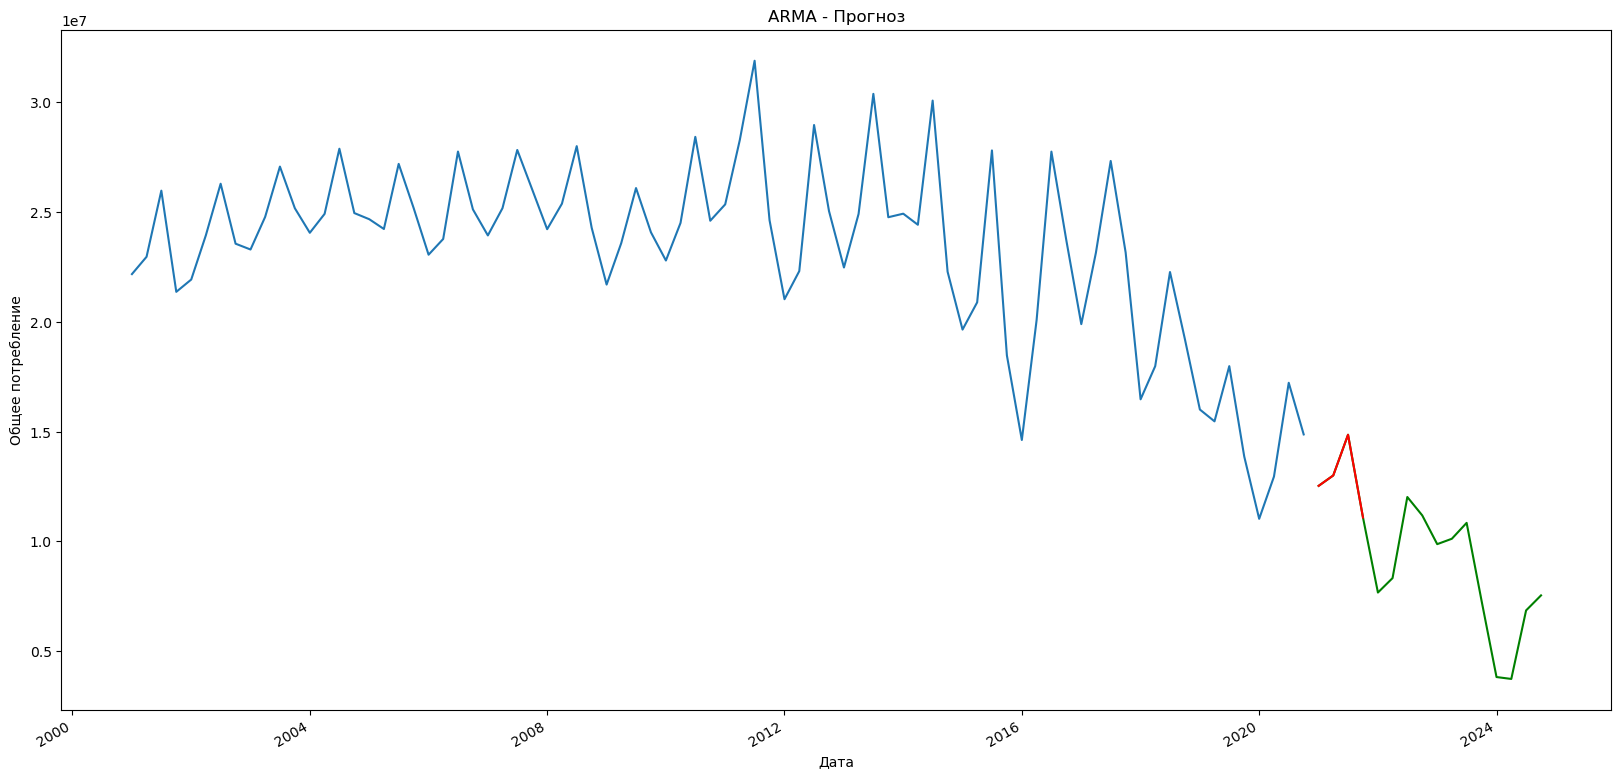

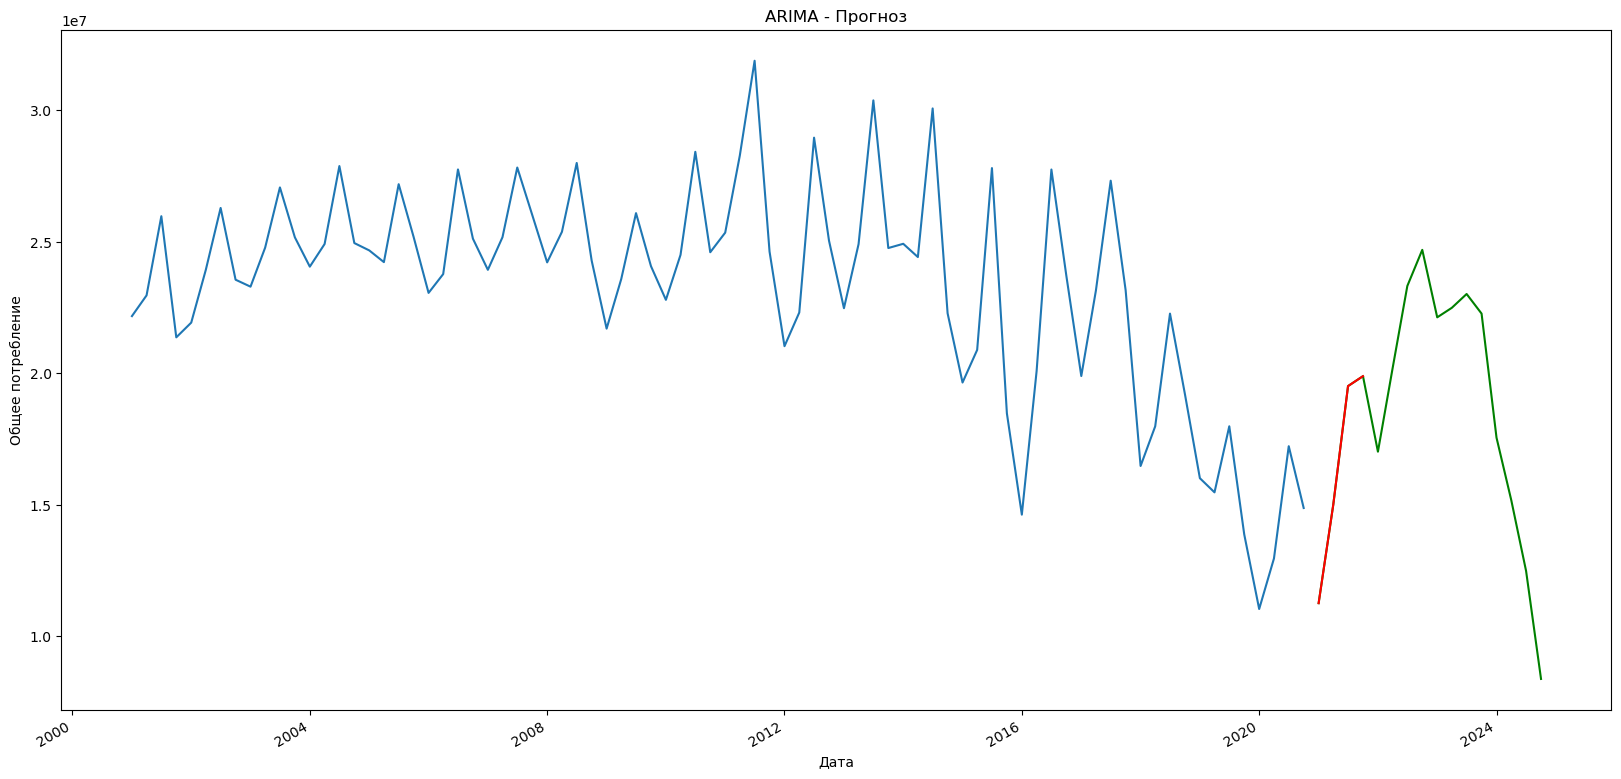

In [28]:
forecast_results = {}

for model_info in best_models:
    if model_info:
        model = SARIMAX(coal, order=(model_info['p'],model_info['d'],model_info['q']),
                                                            seasonal_order=(model_info['P'],model_info['D'],model_info['Q'],4),
                                                            enforce_stationarity=False,
                                                            enforce_invertibility=False)
        result = model.fit(disp=False)
        
        steps_short = 4

        steps_long = 16
        
        forecast_short = result.get_forecast(steps=steps_short)
        forecast_long = result.get_forecast(steps=steps_long)
        
        plt.figure(figsize=(20,10))
        plt.plot(coal, label='Наблюдения')
        forecast_long.predicted_mean.plot(label='Долгосрочный прогноз', color='g')
        forecast_short.predicted_mean.plot(label='Краткосрочный прогноз', color='r')
        plt.title(f"{model_info['model_type']} - Прогноз")
        plt.xlabel('Дата')
        plt.ylabel('Общее потребление')
        plt.show()


подбор гиперпараметров и тестирование моделей ARIMA

In [22]:
arima_model = SARIMAX(coal_diff, order=(1,1,1),seasonal_order=(1,4,4,4),enforce_stationarity=False, enforce_invertibility=False).fit()
print(arima_model.summary())

                                          SARIMAX Results                                           
Dep. Variable:                            Total Consumption   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(1, 4, [1, 2, 3, 4], 4)   Log Likelihood                   0.000
Date:                                      Thu, 26 Sep 2024   AIC                             16.000
Time:                                              12:56:47   BIC                             29.709
Sample:                                          01-01-2002   HQIC                            20.992
                                               - 10-01-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        -15.4239         -0  

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test_arima = acorr_ljungbox(arima_model.resid, lags=[10], return_df=True)
print(lb_test_arima)

     lb_stat  lb_pvalue
10  0.335848   0.999999


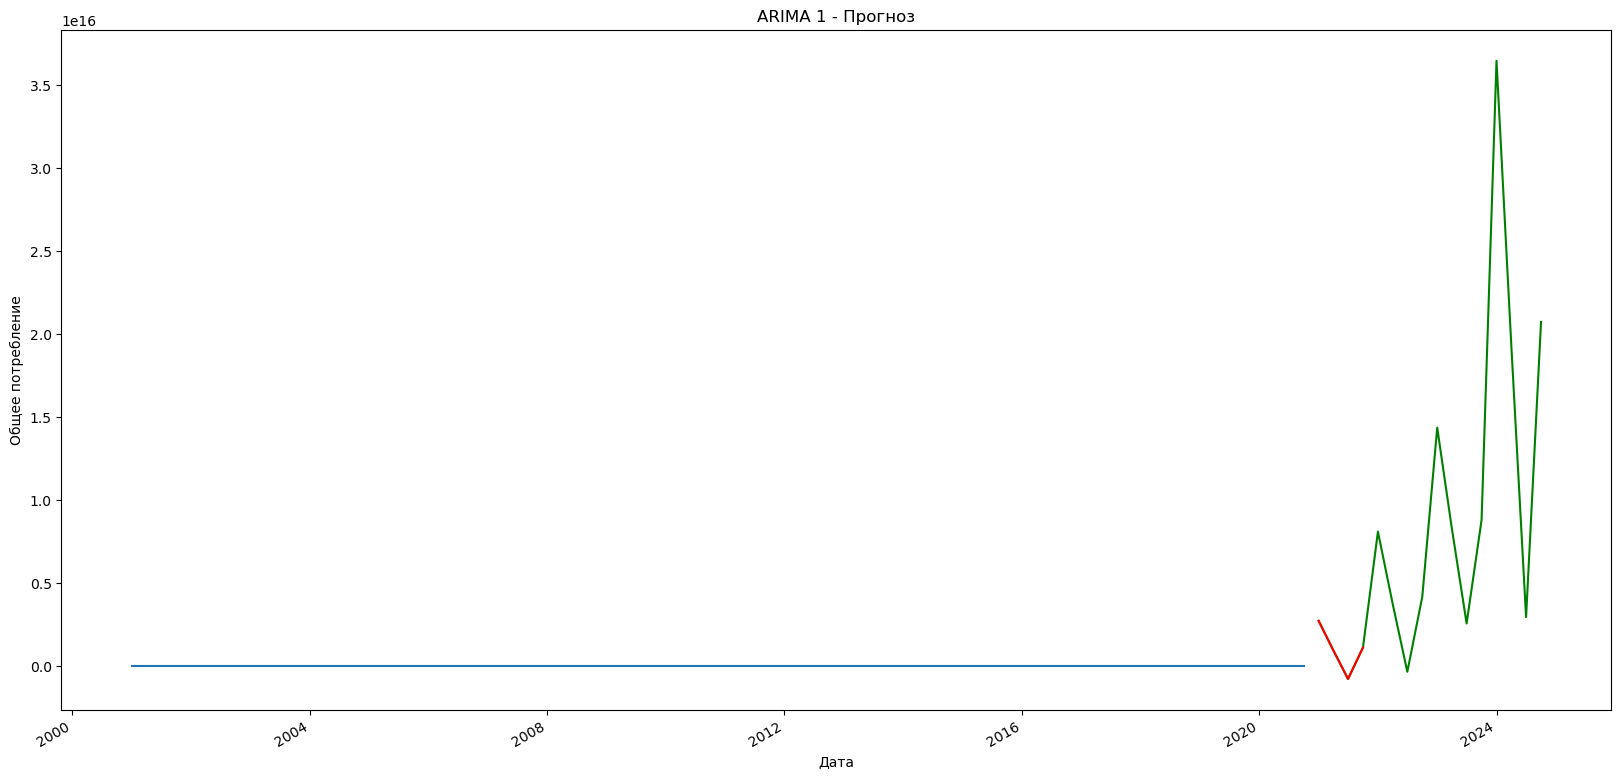

In [25]:
model = SARIMAX(coal, order=(1,1,1),seasonal_order=(1,4,4,4),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
result = model.fit(disp=False)

steps_short = 4

steps_long = 16

forecast_short = result.get_forecast(steps=steps_short)
forecast_long = result.get_forecast(steps=steps_long)

plt.figure(figsize=(20,10))
plt.plot(coal, label='Наблюдения')
forecast_long.predicted_mean.plot(label='Долгосрочный прогноз', color='g')
forecast_short.predicted_mean.plot(label='Краткосрочный прогноз', color='r')
plt.title(f"ARIMA 1 - Прогноз")
plt.xlabel('Дата')
plt.ylabel('Общее потребление')
plt.show()

In [3]:
datasets = {
    "differenced_4": coal.diff(4).dropna()
}

from statsmodels.tsa.statespace.sarimax import SARIMAX

def find_best_model(model_type, p_range, d_range, q_range, seasonal_range, datasets):
    results = []
    for data_name, data in datasets.items():
        for d in d_range:
            for p in p_range:
                for q in q_range:
                    for P in seasonal_range:
                        for D in range(0,3): 
                            for Q in seasonal_range:
                                try:
                                    model = SARIMAX(data, order=(p,d,q),
                                                    seasonal_order=(P,D,Q,4),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    result = model.fit(disp=False)
                                    results.append({
                                        'model_type': model_type,
                                        'data': data_name,
                                        'p': p,
                                        'd': d,
                                        'q': q,
                                        'P': P,
                                        'D': D,
                                        'Q': Q,
                                        'AIC': result.aic,
                                        'model': result
                                    })
                                except:
                                    continue
                        
    if results:
        best_model = min(results, key=lambda x: x['AIC'])
        return best_model
    else:
        return None


p_range_arima = range(1,9)
q_range_arima = range(1,8)
d_range_arima = range(1,9)
seasonal_range = range(0,5)  


best_arima_model2 = find_best_model('ARIMA', p_range_arima, d_range_arima, q_range_arima, seasonal_range, datasets)

In [8]:

from statsmodels.stats.diagnostic import acorr_ljungbox
if best_arima_model2:
    print(f"Лучшая модель {best_arima_model2['model_type']}:")
    print(f"Датасет: {best_arima_model2['data']}")
    print(f"Порядок: ({best_arima_model2['p']}, {best_arima_model2['d']}, {best_arima_model2['q']})")
    print(f"Сезонный порядок: ({best_arima_model2['P']}, {best_arima_model2['D']}, {best_arima_model2['Q']}, 4)")
    print(f"AIC: {best_arima_model2['AIC']}\n")
    print(best_arima_model2['model'].summary())
    

    lb_test = acorr_ljungbox(best_arima_model2['model'].resid, lags=[10], return_df=True)
    print(lb_test)

{'model_type': 'ARIMA', 'data': 'differenced_4', 'p': 1, 'd': 4, 'q': 1, 'P': 2, 'D': 2, 'Q': 4, 'AIC': 18.0, 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000021A82C436B0>}
Лучшая модель ARIMA:
Датасет: differenced_4
Порядок: (1, 4, 1)
Сезонный порядок: (2, 2, 4, 4)
AIC: 18.0

                                          SARIMAX Results                                           
Dep. Variable:                            Total Consumption   No. Observations:                   76
Model:             SARIMAX(1, 4, 1)x(2, 2, [1, 2, 3, 4], 4)   Log Likelihood                   0.000
Date:                                      Thu, 26 Sep 2024   AIC                             18.000
Time:                                              12:17:56   BIC                             34.458
Sample:                                          01-01-2002   HQIC                            24.165
                                               - 10-01-2020                      

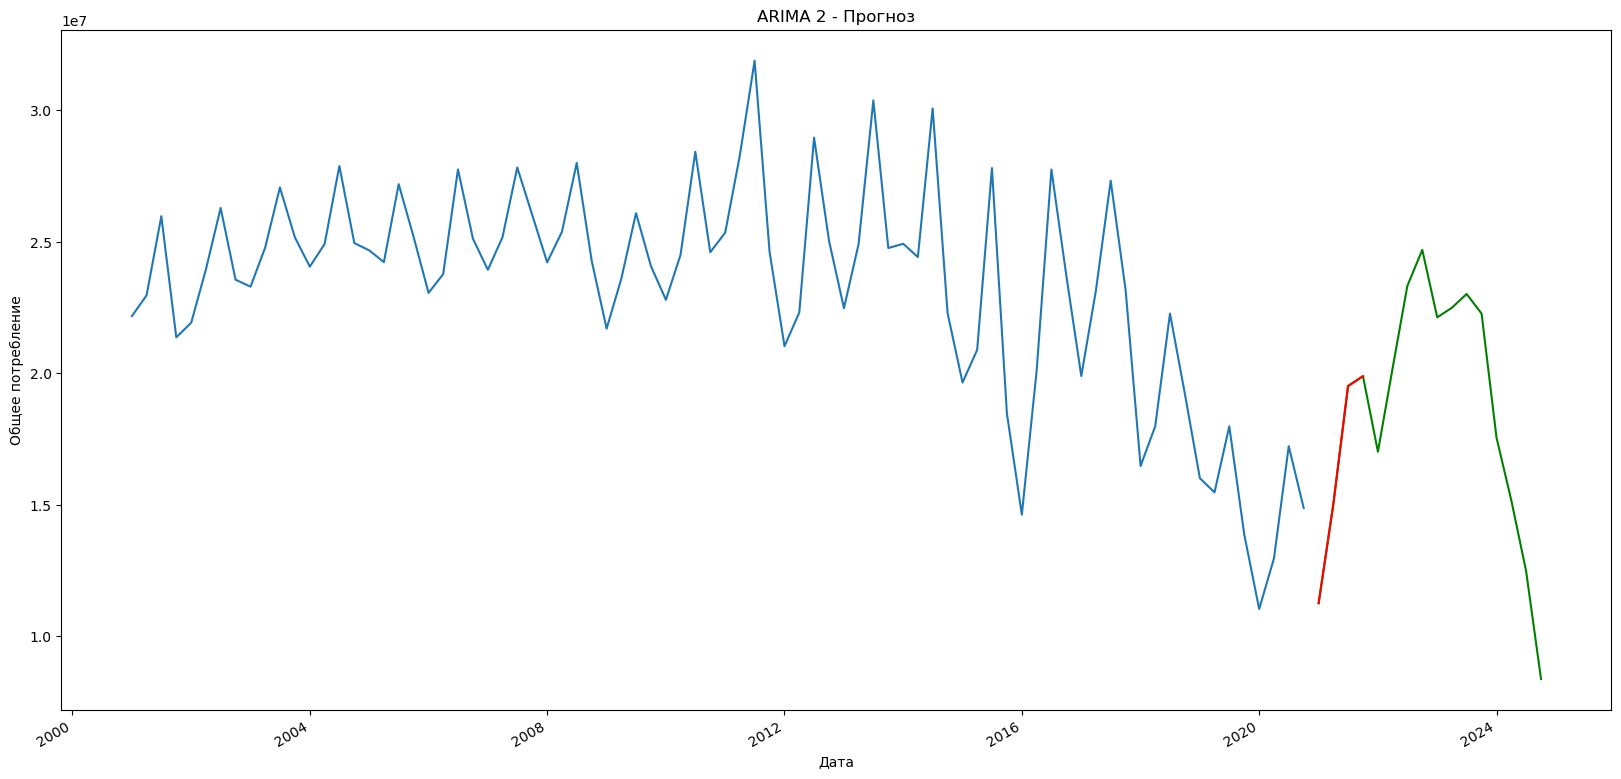

In [24]:
forecast_results = {}


if best_arima_model2:
    model = SARIMAX(coal, order=(best_arima_model2['p'],best_arima_model2['d'],best_arima_model2['q']),
                                                        seasonal_order=(best_arima_model2['P'],best_arima_model2['D'],best_arima_model2['Q'],4),
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)
    result = model.fit(disp=False)
    
    steps_short = 4

    steps_long = 16
    
    forecast_short = result.get_forecast(steps=steps_short)
    forecast_long = result.get_forecast(steps=steps_long)
    
    plt.figure(figsize=(20,10))
    plt.plot(coal, label='Наблюдения')
    forecast_long.predicted_mean.plot(label='Долгосрочный прогноз', color='g')
    forecast_short.predicted_mean.plot(label='Краткосрочный прогноз', color='r')
    plt.title(f"{best_arima_model2['model_type']} 2 - Прогноз")
    plt.xlabel('Дата')
    plt.ylabel('Общее потребление')
    plt.show()